# VDA Length $L$ vs Separation angle $\Delta \Phi$
This notebook utilises the data collected from [PaassiltaEA2018](https://ui.adsabs.harvard.edu/link_gateway/2018SoPh..293...70P/doi:10.1007/s11207-018-1284-7) to plot the calculated VDA length and separation angle values, to be compared to the analytical approximation in Equation 5 of [StraussEA2023 - Onset delays](https://ui.adsabs.harvard.edu/link_gateway/2023ApJ...951....2S/doi:10.3847/1538-4357/acd3ef).

#### Contents
1. [Read the full data file](#Read-the-full-data-file)
2. [Functions to tidy](#Functions-to-tidy)
    1. [Split the nominal and deviation](#Split-the-nominal-and-deviation)
    2. [Convert to datetime objects](#Convert-to-datetime-objects)
3. [Create a relevant data df](#Create-a-relevant-data-df)
4. [Analytical approximation](#Analytical-approx)
5. [Creating df to just connect date lines](#Creating-df-to-just-connect-date-lines)
6. [Plotting](#Plot-the-values)
7. [Final figures](#Final-figures)

In [1]:
# import modules
import os
import numpy as np
import math as mt
import pandas as pd
from datetime import datetime as dt, time, date, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl

# set up colors and themes for plotting
plt.style.use('fast')
spectrum = iter(plt.cm.rainbow(np.linspace(0,1,50)))
cmap = plt.get_cmap('rainbow',50)
colors=['k']
for c in spectrum:
    colors.append(c)

## Read the full data file


Import the tables and try to link the 30+ event dates across all the tables.

In [2]:
# tab_df = pd.read_csv(f"{os.getcwd()}/paassEA18_data.csv",index_col=0, header=[0,1])
# tab_df

### Narrow down the values we need
Specifically, the index/date (in case we need to refer back), the $\Delta \phi$ separation angle, and VDA length (given as $s$ but we refer to it as $L$).

[Back to top](#Contents)

In [3]:
# tab_df.columns

In [4]:
# plot_cols = tab_df[[('Date','Date'),('GOES/STEREO flare','Onset [UT]'),('SOHO 55-80 MeV p+','Onset [UT]'),('SOHO 55-80 MeV p+','delta phi [deg.]'),('SOHO 55-80 MeV p+','VDA s [AU]'),('SOHO 55-80 MeV p+','VDA t0 Date'),('SOHO 55-80 MeV p+','VDA t0 + 500 s [UT]'),('STA/HET 40-100 MeV p+','Onset Date'),('STA/HET 40-100 MeV p+','Onset [UT]'),('STA/HET 40-100 MeV p+','delta phi [deg.]'),('STA/HET 40-100 MeV p+','VDA s [AU]'),('STA/HET 40-100 MeV p+','VDA t0 + 500 s [UT]'),('STB/HET 40-100 MeV p+','Onset Date'),('STB/HET 40-100 MeV p+','Onset [UT]'),('STB/HET 40-100 MeV p+','delta phi [deg.]'),('STB/HET 40-100 MeV p+','VDA s [AU]'),('STB/HET 40-100 MeV p+','VDA t0 Date'),('STB/HET 40-100 MeV p+','VDA t0 + 500 s [UT]')]].copy()
# print(plot_cols)
# plot_cols.to_csv('paassEA18_reduced.csv')

Just read in the file already made...

In [5]:
plot_cols = pd.read_csv('paassEA18_reduced.csv',index_col=0, header=[0,1])

## Functions to tidy


### Split the nominal and deviation
Some columns include an avg $\pm$ std deviation so lets pull that

[Back to top](#Contents)

In [6]:
def remv_pm_signs(x):
    if isinstance(x, str) and len(x)>4:
        splt = x.split()
        if ':' in splt[0]:
            nom_std = [splt[0], splt[2]]
        else:
            nom_std = [float(splt[0]), float(splt[2])]
    else:
        nom_std = [np.nan,np.nan]
#         print(nom_std)
#         print()
    
    return nom_std


### Convert to datetime objects

[Back to top](#Contents)

In [7]:
def convert_dt(item, datum, timum, **kwargs): #string, bool, bool
    
    if pd.isna(item) or (not item[0].isdigit()):
        return np.nan
    
    if 'sep_date' in kwargs:
        new_date = dt.strptime(kwargs['sep_date'], "%Y %b. %d")
        new_item = new_date.replace(hour=int(item[:2]), minute=int(item[3:5]))
                                    
    elif datum and not timum:
        new_item = dt.strptime(item, "%Y %b. %d")
    
    elif datum and timum:
        new_item = dt.strptime(item, "%d/%m/%y %H:%M")
    
    elif timum and not datum:
        new_item = time(hour=int(item[:2]), minute=int(item[3:5])) #dt.strptime(item, "%H:%M")
        
    return new_item

### Create a relevant data df

[Back to top](#Contents)

In [8]:
idx = range(1,47)
dates = []
flare_onset = []

soho_onset = []
soho_delta_phi = []
soho_VDA_s = []
soho_VDA_ser = []
soho_VDA_t0 = []
soho_VDA_terr = []

sta_onset = []
sta_delta_phi = []
sta_VDA_s = []
sta_VDA_ser = []
sta_VDA_t0 = []
sta_VDA_terr = []

stb_onset = []
stb_delta_phi = []
stb_VDA_s = []
stb_VDA_ser = []
stb_VDA_t0 = []
stb_VDA_terr = []

for i in idx:
    dates.append( convert_dt(plot_cols['Date']['Date'][i], True, False) )
    flare_onset.append( convert_dt(plot_cols['GOES/STEREO flare']['Onset [UT]'][i], True, True) )
    
    #soho
    soho_onset.append( convert_dt(plot_cols['SOHO 55-80 MeV p+']['Onset [UT]'][i], True, True, sep_date=plot_cols['Date']['Date'][i]) )
    soho_delta_phi.append(float(plot_cols['SOHO 55-80 MeV p+']['delta phi [deg.]'][i]))
    
    s_nom, s_std = remv_pm_signs(plot_cols['SOHO 55-80 MeV p+']['VDA s [AU]'][i])
    soho_VDA_s.append(s_nom)
    soho_VDA_ser.append(s_std)
    
    t_nom, t_std = remv_pm_signs(plot_cols['SOHO 55-80 MeV p+']['VDA t0 + 500 s [UT]'][i])
    soho_VDA_t0.append(convert_dt(t_nom, True, True, sep_date=plot_cols['SOHO 55-80 MeV p+']['VDA t0 Date'][i]))
    soho_VDA_terr.append(convert_dt(t_std, False, True))
    
    #sta
    sta_onset.append( convert_dt(plot_cols['STA/HET 40-100 MeV p+']['Onset [UT]'][i], True, True, sep_date=plot_cols['STA/HET 40-100 MeV p+']['Onset Date'][i]) )
    sta_delta_phi.append(float(plot_cols['STA/HET 40-100 MeV p+']['delta phi [deg.]'][i]))
    
    s_nom, s_std = remv_pm_signs(plot_cols['STA/HET 40-100 MeV p+']['VDA s [AU]'][i])
    sta_VDA_s.append(s_nom)
    sta_VDA_ser.append(s_std)

    t_nom, t_std = remv_pm_signs(plot_cols['STA/HET 40-100 MeV p+']['VDA t0 + 500 s [UT]'][i])
    sta_VDA_t0.append(convert_dt(t_nom, True, True, sep_date=plot_cols['Date']['Date'][i]))
    sta_VDA_terr.append(convert_dt(t_std, False, True))

    #stb
    stb_onset.append( convert_dt(plot_cols['STB/HET 40-100 MeV p+']['Onset [UT]'][i], True, True, sep_date=plot_cols['STB/HET 40-100 MeV p+']['Onset Date'][i]) )
    stb_delta_phi.append(float(plot_cols['STB/HET 40-100 MeV p+']['delta phi [deg.]'][i]))
    
    s_nom, s_std = remv_pm_signs(plot_cols['STB/HET 40-100 MeV p+']['VDA s [AU]'][i])
    stb_VDA_s.append(s_nom)
    stb_VDA_ser.append(s_std)

    t_nom, t_std = remv_pm_signs(plot_cols['STB/HET 40-100 MeV p+']['VDA t0 + 500 s [UT]'][i])
    stb_VDA_t0.append(convert_dt(t_nom, True, True, sep_date=plot_cols['Date']['Date'][i]))
    stb_VDA_terr.append(convert_dt(t_std, False, True))

df = pd.DataFrame(list(zip(dates, flare_onset, soho_onset, soho_delta_phi, soho_VDA_s, soho_VDA_ser, soho_VDA_t0, soho_VDA_terr, sta_onset, sta_delta_phi, sta_VDA_s, sta_VDA_ser, sta_VDA_t0, sta_VDA_terr, stb_onset, stb_delta_phi, stb_VDA_s, stb_VDA_ser, stb_VDA_t0, stb_VDA_terr)), columns=['date','flare onset', 'soho onset', 'soho Dphi', 'soho s', 'soho serr', 'soho t0','soho terr', 'sta onset', 'sta Dphi', 'sta s', 'sta serr', 'sta t0','sta terr', 'stb onset', 'stb Dphi', 'stb s', 'stb serr', 'stb t0','stb terr'], index=idx)


In [9]:
# df.to_csv('tmp.csv')

In [10]:
spacecraft = [['soho','s','red'],['sta','o','green'],['stb','^','blue']]

### Analytical approx

[Back to top](#Contents)

Using Equation 5 from [StraussEA2023 - Onset delays](https://ui.adsabs.harvard.edu/link_gateway/2023ApJ...951....2S/doi:10.3847/1538-4357/acd3ef) $$\tau = \frac{\Delta s_{||}}{v}\left[ 1 + \frac{\Delta s_{||}}{2\; \lambda_{\perp}} (\Delta \phi)^2 \right]$$ which is plotted kinda in fig2 using $\Delta s_{||}=1.2$ au; $v_e=7$ au/hr; $v_p=1.4$ au/hr; $\lambda_{\perp}=(0.05,0.1,0.5)$ au; and a range of $\Delta \phi$ values.

This code will plot the same equation but in terms of the VDA length $L$, to be compared to VDA $s$ in the PaassiltaEA2018 paper, using $$L = \Delta s_{||}\left[ 1 + \frac{\Delta s_{||}}{2\; \lambda_{\perp}}(\Delta \phi)^2 \right]$$ where $\Delta \phi$ is a range of degrees from -180 to 180 degrees
and converted to radians, and the rest will remain as given in the paper, i.e.:
- $\Delta s_{||}=1.2$ au
- $\lambda_{\perp}=(0.05,0.1,0.5)$ au.

In [11]:
delta_s = 1.2 #au
lambda_perp = [0.05,0.1,0.5]

dphi = np.linspace(-180,180,100)
L0_list = []
L1_list = []
L2_list = []
for d in dphi:
    dd = mt.radians(d)
    L0_list.append(delta_s * (1 + (delta_s/(2*lambda_perp[0]))*(dd**2)  ))
    L1_list.append(delta_s * (1 + (delta_s/(2*lambda_perp[1]))*(dd**2)  ))
    L2_list.append(delta_s * (1 + (delta_s/(2*lambda_perp[2]))*(dd**2)  ))
        
appx = pd.DataFrame(list(zip(dphi, L0_list,L1_list,L2_list)), columns=['dPhi','L0','L1','L2'])


#### Dimensional analysis:
$$L = \Delta s_{||} \left[ 1 + \frac{\Delta s_{||}}{2\; \lambda_{\perp}} (\Delta \phi)^2 \right] [=] {au} \left[ 1 + \frac{{au}}{{au}} ({rad})^2 \right]$$
$$= {au} \left[ 1 + \left(\frac{m}{m}\right)^2 \right] = {au}$$

### Creating df to just connect date lines

[Back to top](#Contents)

In [12]:
df_dates = pd.DataFrame()
date_str = []
for i in df.index:
    dphi_list = []
    s_list = []
    ser_list = []
    t0_list = []
    terr_list = []
    for sc, mk, cl in spacecraft:
        dphi_list.append(df[f"{sc} Dphi"][i])
        s_list.append(df[f"{sc} s"][i])
        ser_list.append(df[f"{sc} serr"][i])
        t0_list.append(df[f"{sc} t0"][i])
        terr_list.append(df[f"{sc} terr"][i])
            
    dt_tmp = df['date'][i].strftime('%d-%b-%Y')
    
    date_str.append(dt_tmp)
    df_dates[ f"{dt_tmp} Dphi" ] = dphi_list
    df_dates[ f"{dt_tmp} s" ] = s_list
    df_dates[ f"{dt_tmp} serr" ] = ser_list
    df_dates[ f"{dt_tmp} t0" ] = t0_list
    df_dates[ f"{dt_tmp} terr" ] = terr_list


/tmp/ipykernel_4923/3010631920.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_dates[ f"{dt_tmp} Dphi" ] = dphi_list
/tmp/ipykernel_4923/3010631920.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_dates[ f"{dt_tmp} s" ] = s_list
/tmp/ipykernel_4923/3010631920.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `

In [13]:
df_dates.to_csv("tmp.csv")

In [14]:
df.columns

Index(['date', 'flare onset', 'soho onset', 'soho Dphi', 'soho s', 'soho serr',
       'soho t0', 'soho terr', 'sta onset', 'sta Dphi', 'sta s', 'sta serr',
       'sta t0', 'sta terr', 'stb onset', 'stb Dphi', 'stb s', 'stb serr',
       'stb t0', 'stb terr'],
      dtype='object')

## Plot the values

[Back to top](#Contents)

In [15]:
def plot_L_delphi_err(df,sclr,eventLines): #dataframe {linear,semilogy,loglog} {events,noEvents}
    fig = plt.figure(figsize=[10,7], dpi=300)
    plt.title(f"Apparent length vs ${{\Delta \Phi}}$",fontsize=11)

    if eventLines=='events':
        for i, d in enumerate(date_str):
            xval = df_dates[f"{d} Dphi"].copy()
            yval = df_dates[f"{d} s"].copy()
            for ii in [0,1,2]:
                if pd.isna(xval[ii]) or pd.isna(yval[ii]):
                    xval.pop(ii)
                    yval.pop(ii)

            plt.plot(xval, yval, marker='', linestyle='solid', 
                     linewidth=1, color=colors[i])
        norm = mpl.colors.Normalize(vmin=0,vmax=46)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, orientation='vertical')
        cbar.set_ticks(range(0,46,4))
        cbar.set_ticklabels([ date_str[idx] for idx in range(0,46,4) ])
        
        
    lmd_pp ='\u03BB'
    perp = '\u27C2'
    plt.plot(appx['dPhi'], appx['L0'], linestyle=':', marker='', color='orange', label=f"{lmd_pp}$_{perp}=0.05$ au")
    plt.plot(appx['dPhi'], appx['L1'], linestyle='-.', marker='', color='aquamarine', label=f"{lmd_pp}$_{perp}=0.1$ au")
    plt.plot(appx['dPhi'], appx['L2'], linestyle='--', marker='', color='violet', label=f"{lmd_pp}$_{perp}=0.5$ au")
    
    
    for sc, mkr, col in spacecraft:
        plt.errorbar(df[f"{sc} Dphi"], df[f"{sc} s"], yerr=df[f"{sc} serr"],
                     fmt=mkr, color=col, markersize=5, capsize=3, 
                     linestyle='none', label=f"{sc} p+")

    
    if sclr == 'linear':
        plt.xscale('linear')
        plt.yscale('linear')
    elif sclr == 'semilogy':
        plt.xscale('linear')
        plt.yscale('log')
    elif sclr == 'loglog':
        plt.xscale('log')
        plt.yscale('log')
        
    
    plt.ylabel('VDA length [au]',fontsize=10)
    plt.xlabel(f"Separation angle [deg.]",fontsize=10)

    plt.grid(color='grey',alpha=0.5, linewidth=0.1)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"Length_sepAngle_err_{sclr}_{eventLines[:3]}.png")
    plt.show()

## Final figures

[Back to top](#Contents)

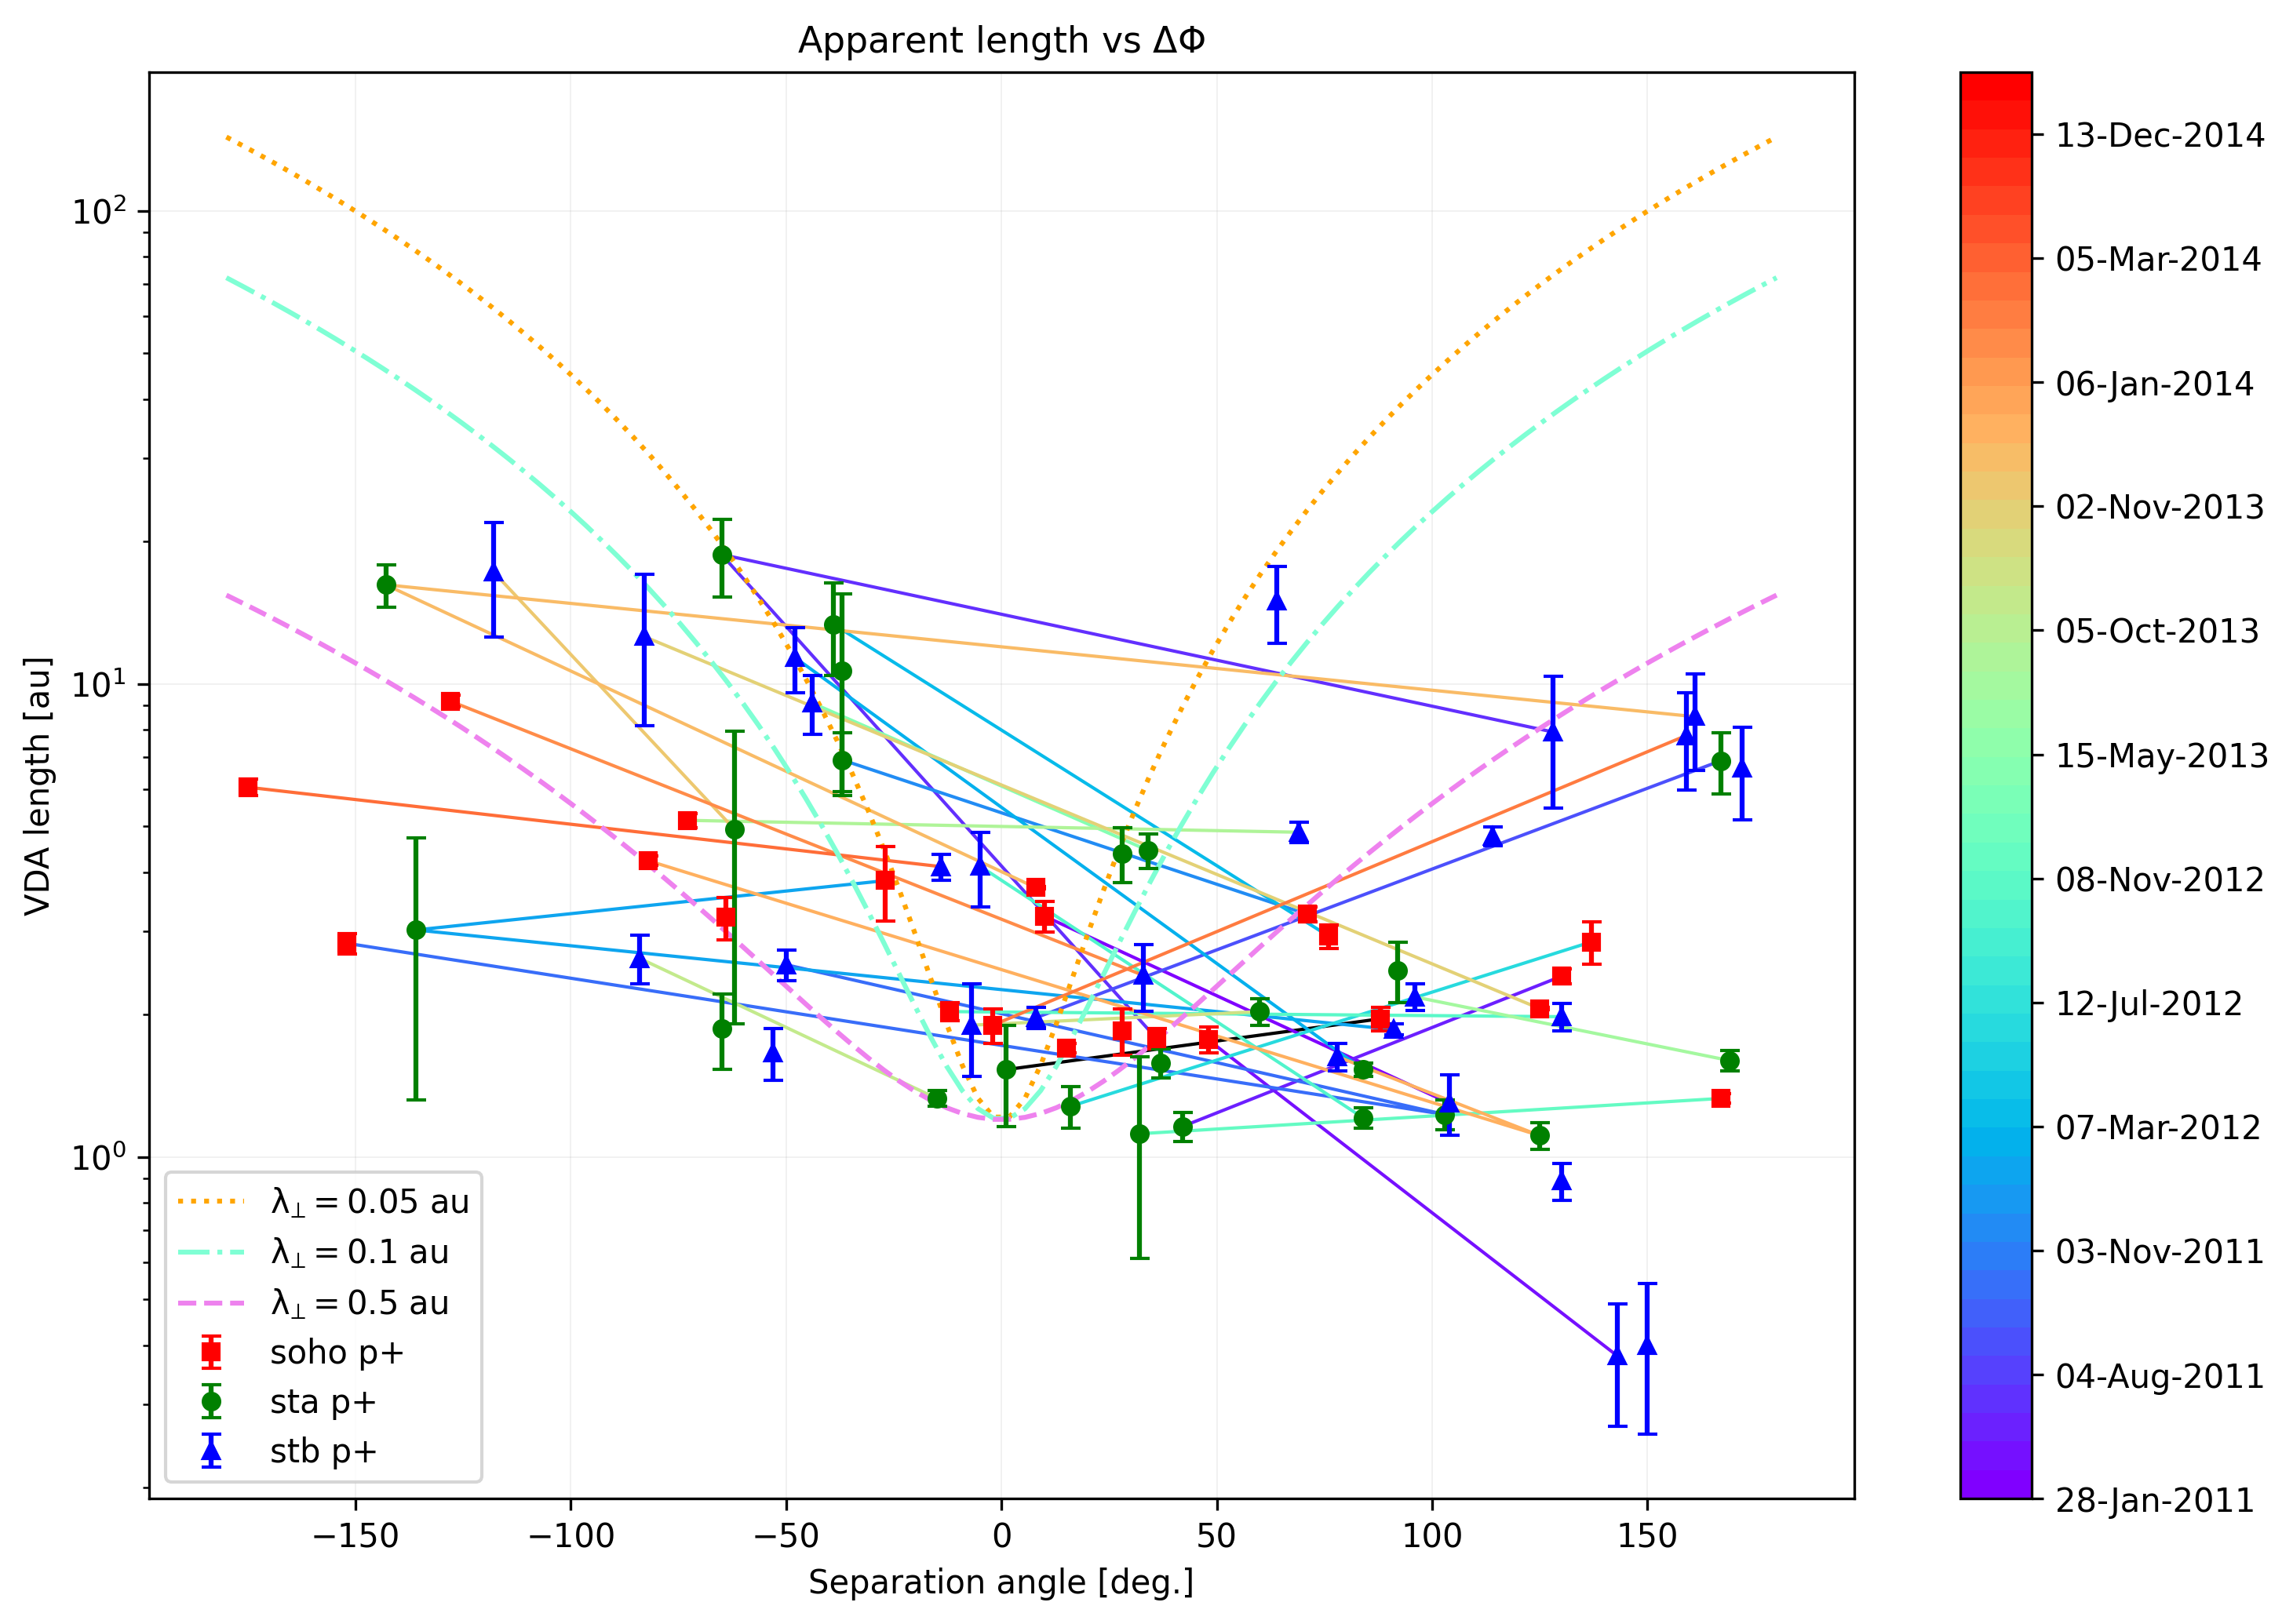

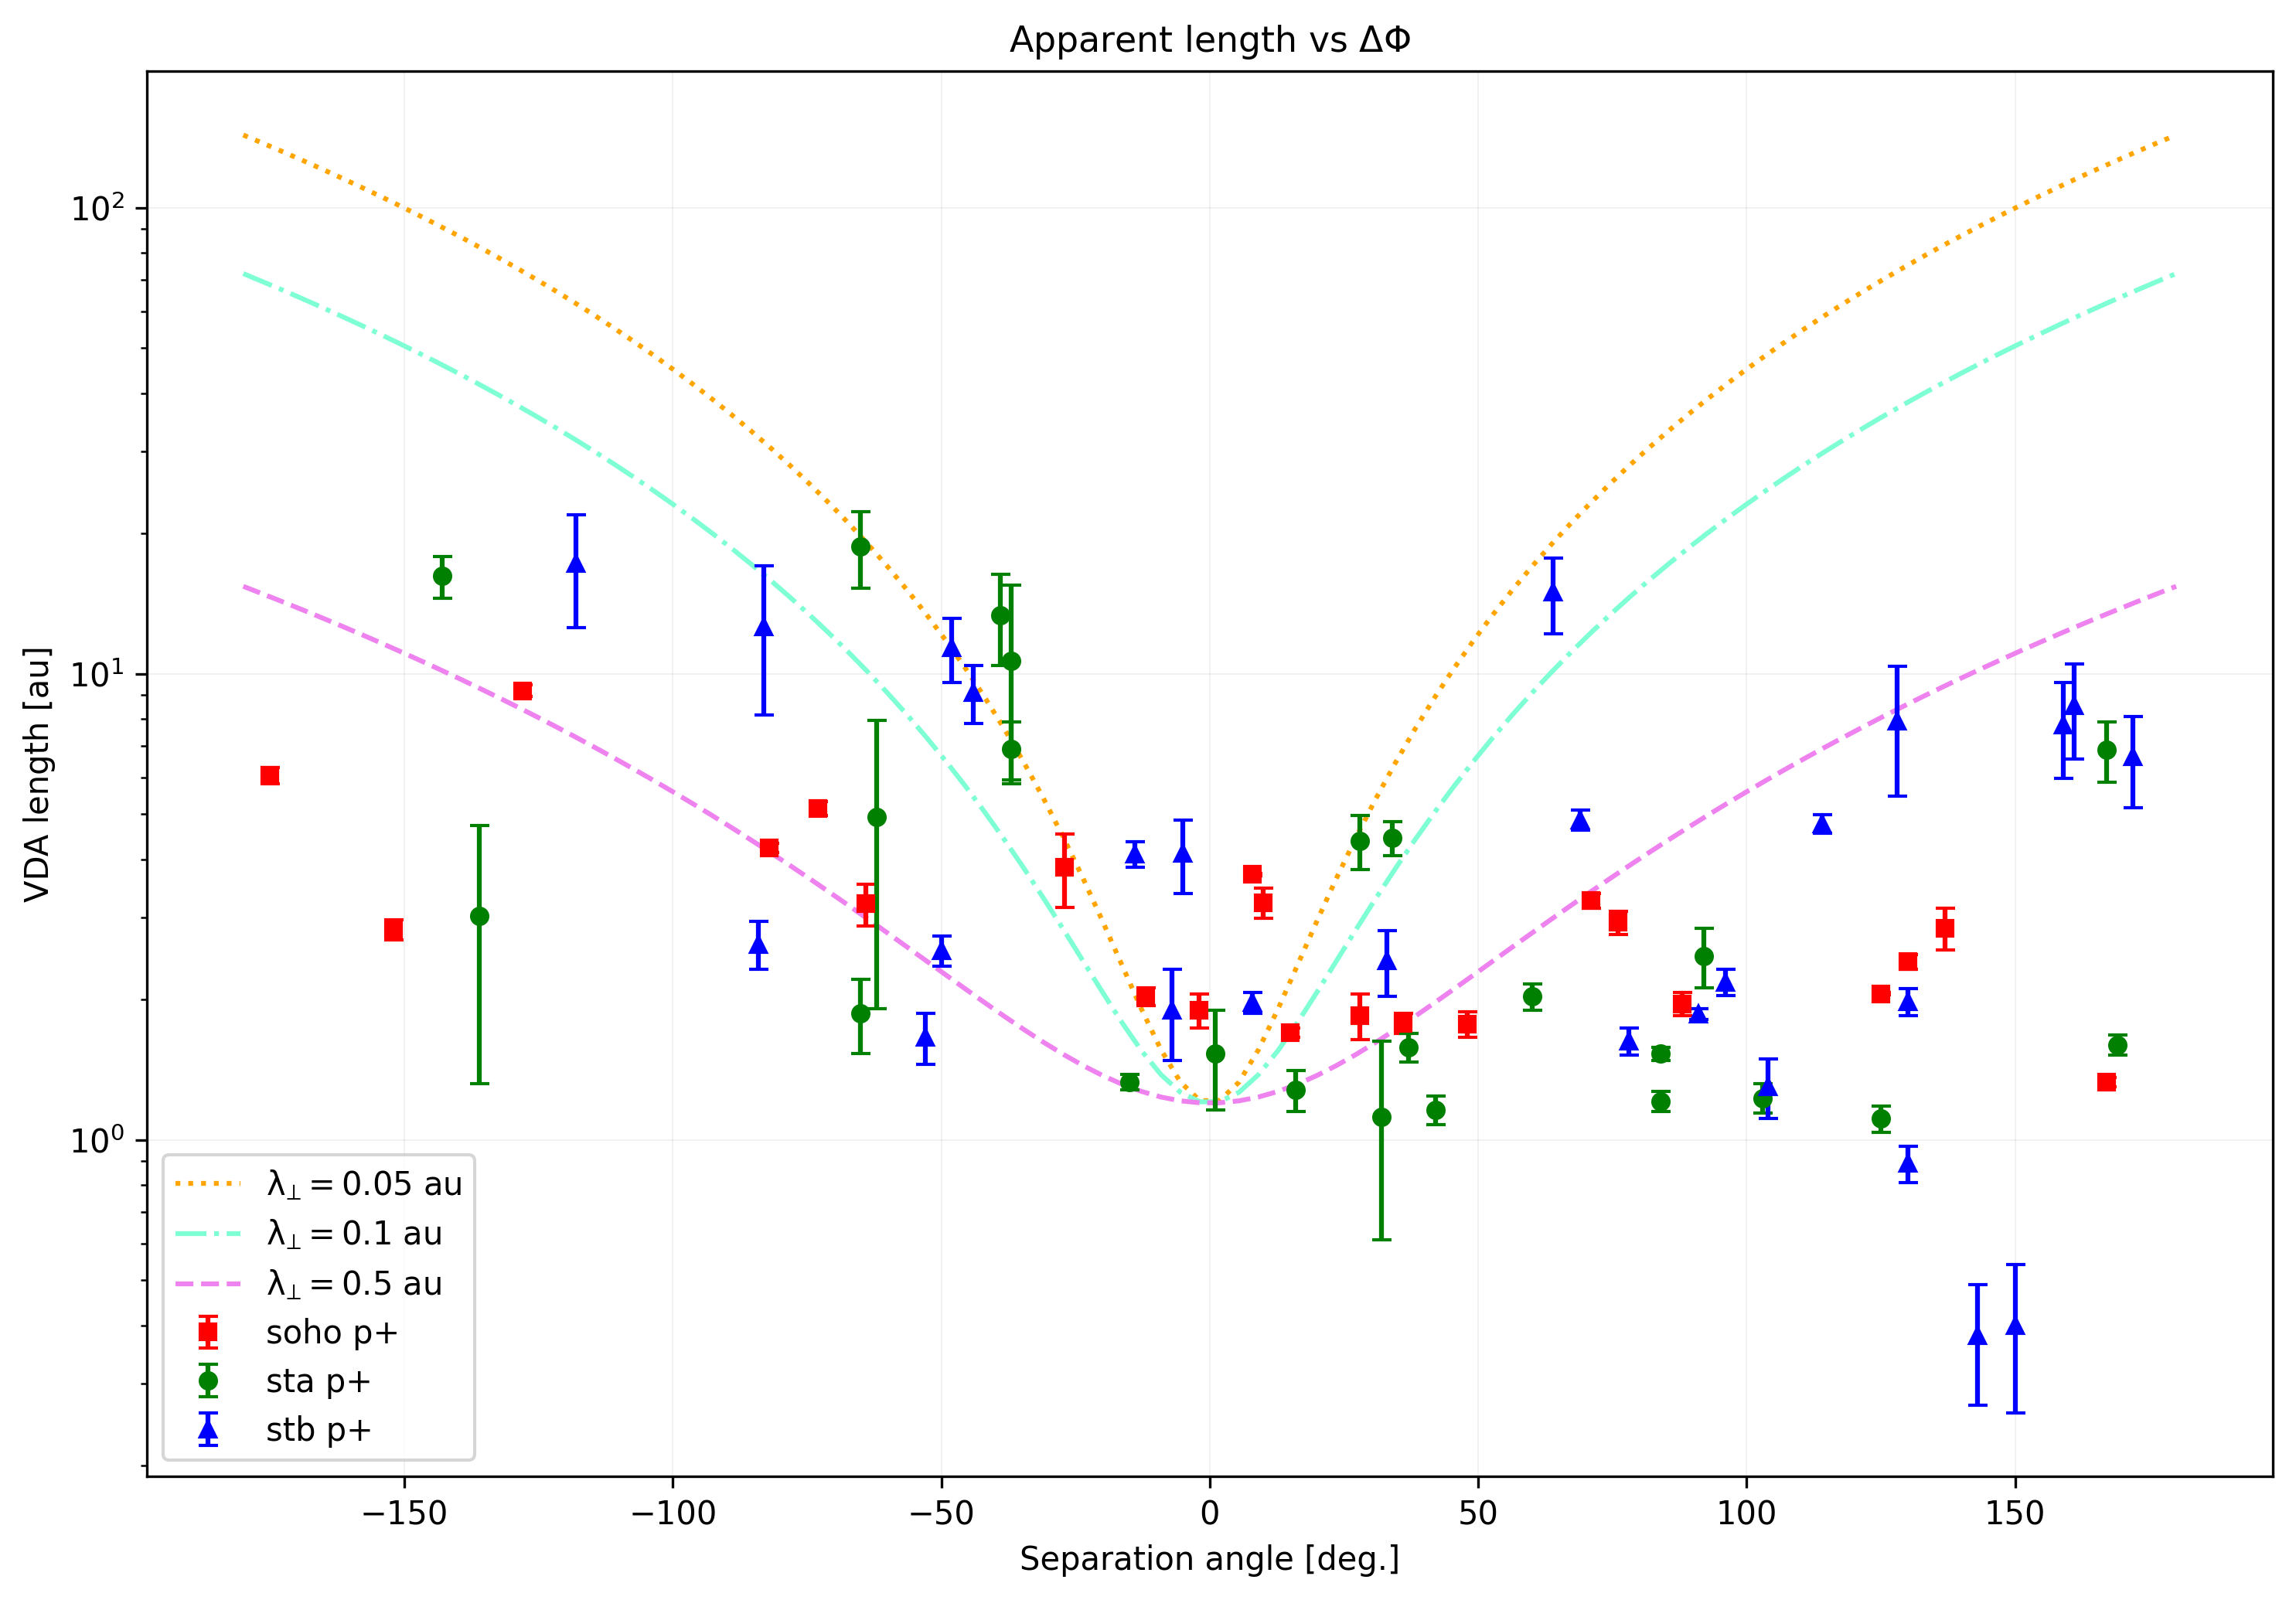

In [16]:
plot_L_delphi_err(df,'semilogy','events')
plot_L_delphi_err(df,'semilogy','noEvents')

[Back to top](#Contents)